# Modelagem

## 1. Resumo

A aplicação escolhida está relacionada com o cálculo de risco de óbito. Foram criados dois modelos de predição de risco de óbito (que varia entre 0 e 1). O primeiro modelo deverá ser utilizado no momento de entrada do paciente em internação e o segundo deverá ser utilizado no decorrer da internação.

## 2. Metodologia

A tarefa escolhida para criação dos modelos é a de classificação. A variável a ser predita será o `desfecho`. Depois de treinar um modelo de classificação, ele será utilizado com uma saída probabilística, sendo este o risco de óbido. Nesta análise foram utilizados os seguintes modelos de classificação:
 - Regressão Ligística (*Logistic Regression*, LGR)
 - Máquinas de Vetores de Suporte de Classificação (*Support Vector Classifiers*, SVC)
 - Classificador K-Vizinhos mais próximos (*K-Neirest Neighborhood*, KNN)
 - Perceptron de Multiplas Camadas (*Multi Layer Perceptron*, MLP)

Para realizar a análise dos classificadores, foi realizada uma validação cruzada. Como que o conjunto de dados é pequeno não seria estatisticamente acurado utilizado o método *hold-out*. Desse modo, o método escolhido foi o *k-fold*, com um k=5. Também foi realizada uma busca em grade (*grid-search*) para alguns dos classificadores.

Antes de aplicar as variáveis a cada um dos métodos de classificação, foi realizado um préprocessamento em cada uma das variáveis, que vai desde codificação de variáveis binárias até tratamento de dados faltantes. A descrição de cada um dos modelos pode ser vista baixo, bem como a descrição do pré-processamento.

### 2.1. Modelo \#1: usado no momento de internação
Como o primeiro modelo é utilizado no momento de entrada na internação, ele não deve utilizar variáveis referentes aos seguintes grupos
 - `Óbito`: contém variáveis discriminantes da saída, como `obito_vm` e `obito_uti` (se uma amostra tem `obito_uti` = "Sim", a variável `desfecho` só pode ser `obito`)
 - `Complicação`: iremos supor que não existem essas informações no momento de internação
 - `Procedimento`: como é o início da internação, consideraremos que nenhum procedimento foi realizado ainda (ou não se tem essa informação)
 - `desfecho`: variável a ser predita
 
Desse modo, as seguintes variáveis serão utilizadas como entrada deste modelo:
 - `coriza`, `tosse_seca_ou_produtiva`, `calafrios`, `febre`, `dispneia`, `fadiga`, `anorexia`, `mialgia`, `astenia`, `dor_de_garganta`, `congestao_nasal`, `cefaleia`, `diarreia`, `nausea`, `vomitos`, `anosmia`, `ageusia`, `tabagismo`, `drogas`, `etilismo`, `diabetes`, `obesidade`, `hipertensao_arterial`, `doenca_cardiaca`, `doenca_pulmonar`, `doenca_reumatologica`, `doenca_autoimune`, `doenca_renal_cronica`, `doenca_hepatica_cronica`, `doenca_neurologica`, `paciente_chegou_com_suporte_respiratorio`, `tempo_referencia_internacao`, `nomemacro`, `idh_label`, `sexo`, `idade`, `cor_autorreferida`, `estado_civil`, `escolaridade`, `tipo_caso_a_admissao`, `tempo_sintomas_internacao`.


### 2.2. Modelo \#2: utilizado ao decorrer da internação
Este modelo será utilizado ao decorrer da internação. Sendo submetido a medida que o paciente vai evoluindo, já que algumas variáveis irão sendo modificadas, como `tempo_internacao`, variáveis relacionadas aos grupos `Complicação` e `Procedimento`, etc. É importante lembrar que as variáveis do grupo `Óbito` também não serão utilizadas nesse modelo, já que são variáveis discriminantes da variável a ser predita.

Desse modo, as variáveis que serão utilizadas como entrada para este modelo são:
 - `coriza`, `tosse_seca_ou_produtiva`, `calafrios`, `febre`, `dispneia`, `fadiga`, `anorexia`, `mialgia`, `astenia`, `dor_de_garganta`, `congestao_nasal`, `cefaleia`, `diarreia`, `nausea`, `vomitos`, `anosmia`, `ageusia`, `tabagismo`, `drogas`, `etilismo`, `diabetes`, `obesidade`, `hipertensao_arterial`, `doenca_cardiaca`, `doenca_pulmonar`, `doenca_reumatologica`, `doenca_autoimune`, `doenca_renal_cronica`, `doenca_hepatica_cronica`, `doenca_neurologica`, `paciente_chegou_com_suporte_respiratorio`, `vmi`, `uti`, `necessidade_transfusional`, `fenomenos_tromboembolicos_tvp`, `fenomenos_tromboembolicos_tep`, `sepse`, `disfuncao_hepatica`, `choque_septico`, `disfuncao_multipla_de_orgaos`, `choque_hipovolemico`, `complicacao_neurologica`, `hemorragia`, `hemodialise`, `tempo_referencia_internacao`, `nomemacro`, `idh_label`, `sexo`, `idade`, `cor_autorreferida`, `estado_civil`, `escolaridade`, `tipo_caso_a_admissao`, `tempo_sintomas_internacao`.


### 2.3. Observações

Algumas variáveis também foram removidas, a saber:
 - `longitude`, `latitude`, `bairro`: como só residentes em fortaleza tem esse tipo de informação;
 - `paciente_id`: não tem relação com os dados do paciente.

### 2.4. Pré-processamento

Como a grande maioria das variáveis não é numerica por natureza, foi realizado alguns passos de pré-processamenton nos dados, a saber:
 - **Codificação**:
     - Variáveis do tipo `Booleana`  e `Texto` foram codificadas utilizadno o método *one-hot-encoding*
 - **Dados faltantes**: 
     - Variáveis do grupo `Inteiro` foram tratadas inputando a mediana dos valores
     - Variáveis do grupo `Texto` e `Booleano` foram tratadas inputando a mediana dos valores

#### 2.4.1. Codificação
- `Booleana`: OneHotEncoder dropfirst
- `Texto`: OneHotEncoder

#### 2.4.2. Dados faltantes
 - `Inteiro`: mediana
 - `Texto`, `Booleano`: most_frequent

#### 2.4.3. Normalização
 - Antes de aplicar o classificador, cada uma das variáveis foi normalizada utilizando o método *z-score*.


---

Abaixo serão apresentados os códigos necessários e os resultados obitidos.

## 3. Implementação

### 3.1. Importação de bibliotecas

In [1]:
from pathlib import Path
import json
import joblib

import pandas as pd
# validação cruzada e métricas
from sklearn.model_selection import cross_validate, StratifiedKFold
# preprocessamento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# modelos
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# métodos próprios
from src.data import prepare, visualize
from src import misc

### 3.2. Carregamento de dados

In [2]:
dict_path = Path("../data/processed/dicionario.csv") # path do dicionário de dados
data_path = Path("../data/processed/dataset_teste_selecao.csv") # path do conjunto de dados
df_dict = pd.read_csv(dict_path)

df = pd.read_csv(data_path)
df.desfecho.replace(["alta", "obito"], [0, 1], inplace=True)

### 3.3. Seleção de dados

In [3]:
# preparar dados para o modelo #1
excluded_groups_model1 = ["Óbito", "Complicação", "Procedimento"]
cols_model1 = prepare.get_columns(df, df_dict, excluded_groups_model1)
X_model1, y_model1 = prepare.get_Xy(df, cols_model1)
preprocessor_model1 = prepare.get_preprocessor(cols_model1)

# preparar dados para o modelo #2
excluded_groups_model2 = ["Óbito"]
cols_model2 = prepare.get_columns(df, df_dict, excluded_groups_model2)
X_model2, y_model2 = prepare.get_Xy(df, cols_model2)
preprocessor_model2 = prepare.get_preprocessor(cols_model2)

### 3.4. Preparação de classificadores
#### 3.4.1. Configuração

In [4]:
# Geral
general_params = {'max_iter': 1000, 'random_state': 42}

# MLP
n_layers = 3
layer_size = 100
mlp_params = {
    "hidden_layer_sizes": [layer_size for _ in range(n_layers)], 
    "activation": "relu",
    "solver": "adam",
    "alpha": 0.001
}

# KNN
knn_params = {'n_neighbors': 15, 'n_jobs': -1}

# random forest
rf_params = {'cv': 5}

# support vector machines
svc_params = {'probability': True}

#### 3.4.2. Criação

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

classifiers = {
    "LGR": LogisticRegressionCV(**general_params, **rf_params),
    "KNN": KNeighborsClassifier(**knn_params),
    "MLP": MLPClassifier(**general_params, **mlp_params),
    "SVC": SVC(**general_params, **svc_params)
}

## 4. Resultados e discussão

In [6]:
metrics = ['accuracy', 'precision', 'recall', 'f1']
n_folds = 5

### 4.1. Modelo \#1

In [7]:
results = {classifier_name: None for classifier_name in classifiers}
for classifier_name, classifier in classifiers.items():
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor_model1),
            ('model', classifier)
        ]
    )
    results[classifier_name] = cross_validate(
        clf, X_model1, y_model1, 
        cv=StratifiedKFold(n_splits=n_folds, random_state=general_params['random_state'], shuffle=True),
        n_jobs=-1,
        scoring=metrics
    )
final_results = misc.results_to_df(results)
final_results

,model,metric,mean,std
2,LGR,test_accuracy,0.678261,0.040320
3,LGR,test_precision,0.616628,0.053688
4,LGR,test_recall,0.519334,0.092252
5,LGR,test_f1,0.561910,0.073243
8,KNN,test_accuracy,0.626087,0.033112
9,KNN,test_precision,0.549384,0.054872
10,KNN,test_recall,0.411193,0.045202
11,KNN,test_f1,0.468805,0.039875
14,MLP,test_accuracy,0.629565,0.034013
15,MLP,test_precision,0.541674,0.045434


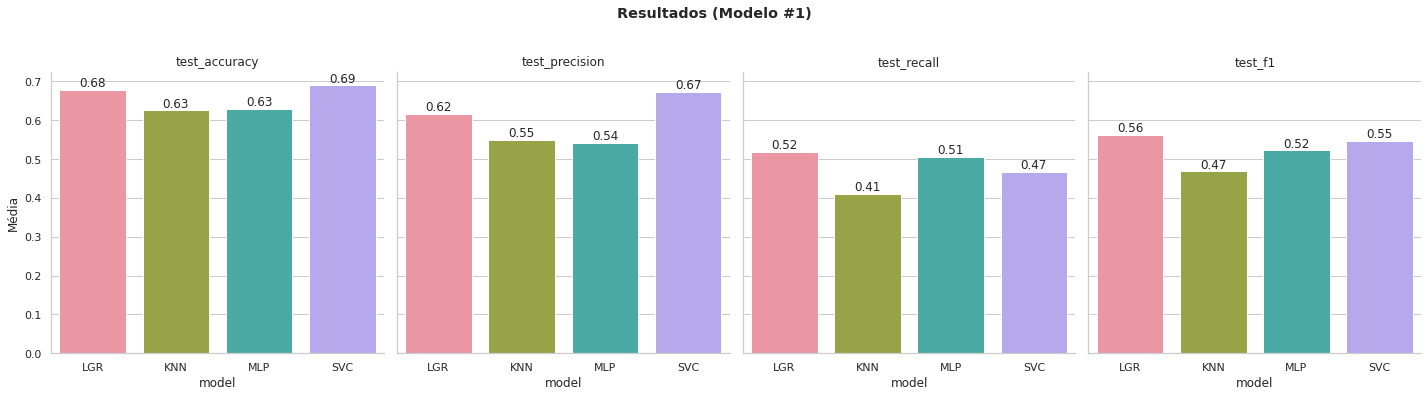

In [8]:
visualize.results_plot(final_results, "Resultados (Modelo #1)")

---

 - O Modelo SVC obteve melhores resultados nas métricas Acurácia, Precisão e F1-Score
 - Na métrica Recall, o modelo SVC obteve a terceira colocação. No entanto, todos mantém resultados parecidos

---

### 4.2. Modelo \#2

In [9]:
results = {classifier_name: None for classifier_name in classifiers}
for classifier_name, classifier in classifiers.items():
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor_model2),
            ('model', classifier)
        ]
    )
    results[classifier_name] = cross_validate(
        clf, X_model2, y_model2, 
        cv=StratifiedKFold(n_splits=n_folds, random_state=general_params['random_state'], shuffle=True),
        n_jobs=-1,
        scoring=metrics
    )
final_results = misc.results_to_df(results)
final_results

,model,metric,mean,std
2,LGR,test_accuracy,0.949565,0.011338
3,LGR,test_precision,0.947110,0.018991
4,LGR,test_recall,0.926364,0.024916
5,LGR,test_f1,0.936393,0.015069
8,KNN,test_accuracy,0.840000,0.007778
9,KNN,test_precision,0.972857,0.015208
10,KNN,test_recall,0.619056,0.018861
11,KNN,test_f1,0.756472,0.014950
14,MLP,test_accuracy,0.930435,0.016268
15,MLP,test_precision,0.924774,0.024288


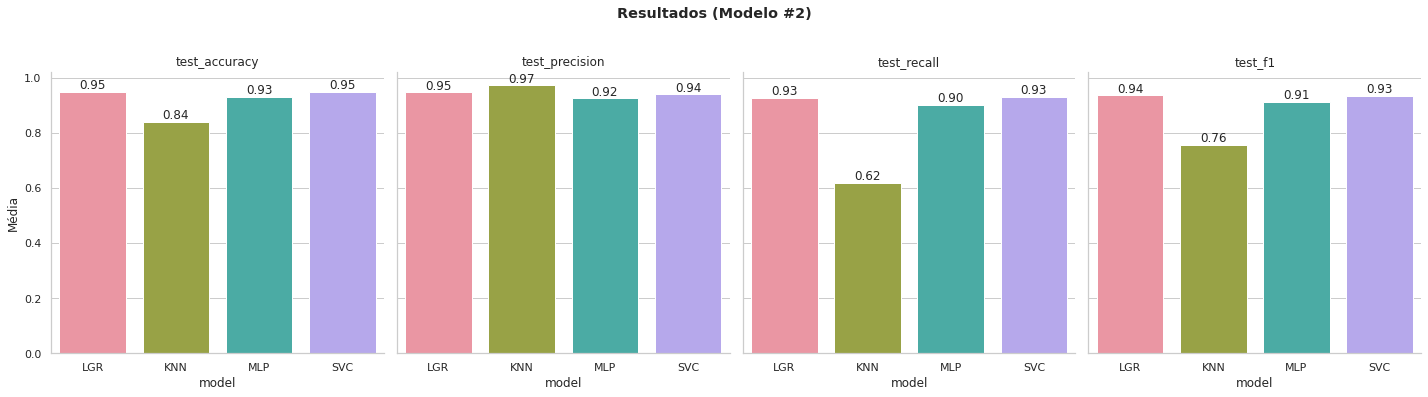

In [10]:
visualize.results_plot(final_results, "Resultados (Modelo #2)")

---

 - Em média, o modelo LGR se sai melhor quando comparado aos outros.
 - O modelo KNN é o mais instável.

---

## 5. Serialização de modelos

Depois de escolhidos os modelos através da validação cruazda apresentada, SVC para o modelo \#1 e LGR para o modelo \#2. Treinamos novamente os classificadores, agora com todos os dados, e salvamos na pasta models para posterior utilização.

In [11]:
# Modelo #1
model1 = Pipeline(steps=[('preprocessor', preprocessor_model1), ('model', classifiers["SVC"])])
model1.fit(X_model1, y_model1)
joblib.dump(model1, Path('../models/model1.pkl'))


# Modelo #2
model2 = Pipeline(steps=[('preprocessor', preprocessor_model2), ('model', classifiers["LGR"])])
model2.fit(X_model2, y_model2)
joblib.dump(model2, Path('../models/model2.pkl'))

['../models/model2.pkl']

## 6. Conclusão

Neste arquivo foram criados dois modelos pra utilização em calculo de risco aplicado a pacientes internados por COVID19. Foi realizada uma análise comparativa entre 4 classificadores (para cada modelo). O Modelo \#1 apresenta resultados não muito animadores, porém é importante lembrar que tal modelo utiliza apenas informações anteriores a internação. O Modelo \#2 obteve resultados (aplicado a pacientes já internados) obteve resultados animadores, o melhor classificador deste modelo obteve 95% de acurácia, e 94% F1-Score.

## 7. Observações
 - Embora fosse possível melhorar as taxas de acerto utilizando métodos de busca em grade ou mesmo comitês de classificadores, optou-se por utilizar os modelos de maneira mais simples, visto que demoraria mais tempo para reprodução dos notebooks.